# MPS-based State Preparation

This is a demonstration of our state preparation technique as described in [Phys. Rev. Applied 18, 024013](https://doi.org/10.1103/PhysRevApplied.18.024013) ([arXiv:2110.13454](https://arxiv.org/abs/2110.13454))

The final output of our technique are the unitary matrices corresponding to gates on a quantum computer. This is system-agnostic and should be easily adaptable to any other provider, and not just IBMQ.

Note that Qiskit will be required to run the cells that convert the unitaries into a Qiskit quantum circuit to extract the circuit depth and number of gates. Qiskit is not required to generate the unitary matrices themselves.

To enable the use of Qiskit in this example (assuming you have it installed it already, otherwise please see installation instructions [here](https://qiskit.org/documentation/getting_started.html)), please set the variable `use_qiskit` to `True` below.

In [1]:
use_qiskit = True

## Import libraries

In [2]:
from mpsprep import MatrixProductState, MatrixProductInitializer
from mpsprep.helpers import (
    mean_fractional_entropy, coarse_truncate_s_vals,
    ranks_from_s_vals, state_fidelity,
    best_s_val_truncation_idx, 
    truncate_s_vals, generate_target_state,
)

import numpy as np
import matplotlib.pyplot as plt

if use_qiskit:
    from qiskit import QuantumCircuit, QuantumRegister, execute, Aer, transpile
    from qiskit.quantum_info import Operator

# 1. Random Sparse
Generate a random sparse 8-qubit statevector

In [3]:
num_qubits = 8
case = "random"
seed = 2022
sparsity = 0.98

x, y_amp = generate_target_state(num_qubits, case, seed, sparsity)

print(f"Mean Fractional Entropy of Target: {mean_fractional_entropy(y_amp):.5f}")

Mean Fractional Entropy of Target: 0.39478


In [4]:
y_tensor = y_amp.reshape((2,)*num_qubits, order="F")

## 1.1 Plot the statevector for visualization

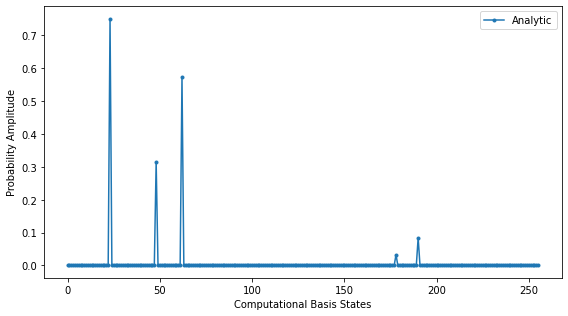

In [5]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.legend()
plt.tight_layout()
plt.show()

# 1.2 Exact MPS

We first prepare the target statevector exactly using our technique.

In [6]:
MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(y_tensor)

We consider singular values smaller than $10^{-15}$ to be non-zero only because of finite numerical precision and therefore drop them with `coarse_truncate_s_vals`. The threshold of $10^{-15}$ can be adjusted by supplying an argument to `coarse_truncate_s_vals`. We then redo the SVD but specify the ranks to obtain the "coarsely truncated" MPS cores. These will be defined as the new `MPS_cores_exact`.

In [7]:
coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact)
coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals)

MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(y_tensor, truncate_ranks=coarse_truncated_ranks)
MPS_exact = MatrixProductState(MPS_cores_exact)

Plot the singular values to visualize the entanglement in the system.

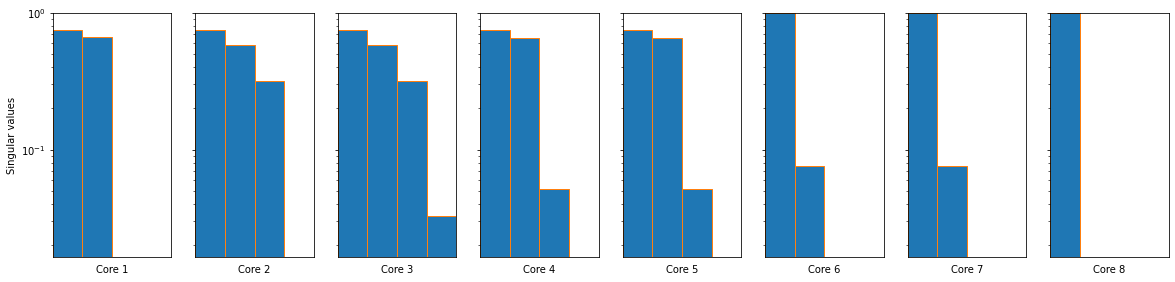

In [8]:
MPS_exact.plot_singular_values(s_vals_exact)

In [9]:
MPS_exact.right_normalize("F")
y_mps_exact = MPS_exact.get_all_amplitudes()

print(f"State Fidelity (Exact): {state_fidelity(y_amp, y_mps_exact):.5f}")

State Fidelity (Exact): 1.00000


## 1.2.1 Plot the target statevector and the amplitudes from the MPS cores

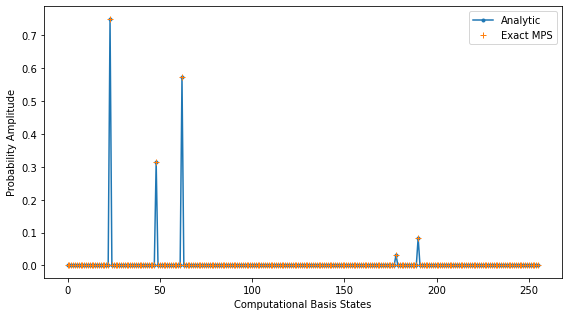

In [10]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.plot(x, np.abs(y_mps_exact), "+", label="Exact MPS")
plt.legend()
plt.tight_layout()
plt.show()

## 1.2.2 Use the MPI to generate the gate unitaries needed to prepare this state

In [11]:
MPI_exact = MatrixProductInitializer(MPS_exact)
unitaries_exact = MPI_exact.gate_unitaries(False)

In [12]:
if use_qiskit:
    operators = [Operator(unitary) for unitary in unitaries_exact]

    qc_exact = QuantumCircuit(MPI_exact.num_qubits)
    for m, operator in enumerate(operators):
        nqubit = int(np.log2(unitaries_exact[m].shape[-1]))
        qubits_list = list(range(m, m + nqubit))
        qc_exact.unitary(operator, qubits_list)

    qc_exact_basis = transpile(qc_exact, basis_gates=["u1", "u2", "u3", "cx"],
                               optimization_level=3)

    circuit_gates_exact = qc_exact_basis.count_ops()
    total_gates_exact = sum(qc_exact_basis.count_ops().values())
    circuit_depth_exact = qc_exact_basis.depth()

    print("Gate Count")
    for key, val in circuit_gates_exact.items():
        print(f"{key}: {val}")

    print(f"\nTotal Gates: {total_gates_exact}")
    print(f"Circuit Depth: {circuit_depth_exact}")

Gate Count
cx: 127
u3: 105
u2: 53
u1: 27

Total Gates: 312
Circuit Depth: 241


# 1.3 Approximate MPS

Given a $Q$ qubit system, there are $Q - 1$ non-trivial successive SVDs to perform on matrices $B^n$, $n = 0, \ldots, Q-1$. To obtain the next best approximation, the smallest singular value, relative to the largest singular value in the same SVD, should be dropped.

However, the requirement of the MPS to be right normalizable places the constraint that $\text{rank}(B^{n-1}) \leq 2\, \text{rank}(B^n)$ which may limit our options for truncating singular values. The function `best_s_val_truncation_idx` takes this into account when finding the most optimal singular value to drop.

In [13]:
max_ratio_idx = best_s_val_truncation_idx(s_vals_exact)
truncated_s_vals = truncate_s_vals(s_vals_exact, max_ratio_idx)
truncated_ranks = ranks_from_s_vals(truncated_s_vals)

We see that the smallest singular value in the 3rd MPS core was dropped during the approximation:

In [14]:
print(f"Exact Ranks  : {coarse_truncated_ranks}")
print(f"Approx Ranks : {truncated_ranks}")

Exact Ranks  : [2 3 4 3 3 2 2 1]
Approx Ranks : [2 3 3 3 3 2 2 1]


## 1.3.1 Generate the MPS cores that represent this approximate state

In [15]:
MPS_cores_approx, s_vals_approx = MatrixProductState.svd_decompose(y_tensor, truncate_ranks=truncated_ranks)

MPS_approx = MatrixProductState(MPS_cores_approx)
MPS_approx.right_normalize("F")

y_mps_approx = MPS_approx.get_all_amplitudes()

MPI_approx = MatrixProductInitializer(MPS_approx)
unitaries_approx = MPI_approx.gate_unitaries(False)

print(f"State Fidelity (1 Singular Val Dropped): {state_fidelity(y_amp, y_mps_approx):.5f}")

State Fidelity (1 Singular Val Dropped): 0.99893


Plot the singular values of the exact and approximate MPS to see the effect of the truncation. The main difference is in `Core 3` which had 1 singular value dropped, but we also see that this caused the singular values in subsequent cores to also change slightly.

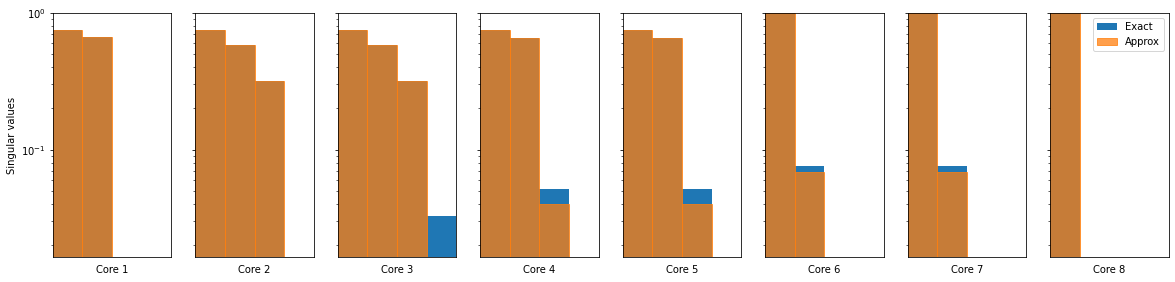

In [16]:
yscale = "log"
ylabel = "Singular values"

max_length = np.max([len(s_val) for s_val in s_vals_exact])
max_sval = np.max([np.max(s_val) for s_val in s_vals_exact])
min_sval = np.min([np.min(s_val) for s_val in s_vals_exact])

min_sval = max(min_sval, 1e-20)

subplot_kwargs = {"ncols": len(s_vals_exact),
                  "figsize": (2.5*len(s_vals_exact), 4.5),
                  "sharey": True}
bar_kwargs_exact = {"width": 1, "label": "Exact"}
bar_kwargs_approx = {"width": 1, "edgecolor": "C1",
                     "label": "Approx", "alpha": 0.75}

_, axes = plt.subplots(**subplot_kwargs)
for m, ax in enumerate(axes):
    s_val_exact = s_vals_exact[m]
    s_val_approx = s_vals_approx[m]
    if m == 0:
        ax.set_yscale(yscale)
        ax.set_ylabel(ylabel)
    ax.bar(np.arange(len(s_val_exact)), s_val_exact, **bar_kwargs_exact)
    ax.bar(np.arange(len(s_val_approx)), s_val_approx, **bar_kwargs_approx)
    ax.set_xlim(-0.5, max_length - 0.5)
    ax.set_ylim(min_sval/2, max_sval)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(f"Core {m+1}")

plt.legend()
plt.show()

## 1.3.2 Plot the target statevector and the amplitudes from the approx MPS cores

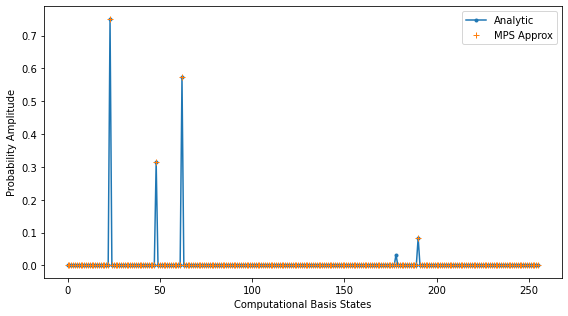

In [17]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.plot(x, np.abs(y_mps_approx), "+", label="MPS Approx")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
if use_qiskit:
    operators = [Operator(unitary) for unitary in unitaries_approx]

    qc_approx = QuantumCircuit(MPI_approx.num_qubits)
    for m, operator in enumerate(operators):
        nqubit = int(np.log2(unitaries_approx[m].shape[-1]))
        qubits_list = list(range(m, m + nqubit))
        qc_approx.unitary(operator, qubits_list)

    qc_approx_basis = transpile(qc_approx, basis_gates=["u1", "u2", "u3", "cx"],
                                optimization_level=3)

    circuit_gates_approx = qc_approx_basis.count_ops()
    total_gates_approx = sum(qc_approx_basis.count_ops().values())
    circuit_depth_approx = qc_approx_basis.depth()

    print("Gate Count")
    for key, val in circuit_gates_approx.items():
        print(f"{key}: {val}")

    print(f"\nTotal Gates: {total_gates_approx}")
    print(f"Circuit Depth: {circuit_depth_approx}")

Gate Count
cx: 104
u3: 87
u2: 48
u1: 23

Total Gates: 262
Circuit Depth: 199


# 1.4 Compare exact state vs approximate state preparation

In [19]:
print("State Fidelity")
print(f"Exact  : {state_fidelity(y_amp, y_mps_exact):.5f}")
print(f"Approx : {state_fidelity(y_amp, y_mps_approx):.5f}")

if use_qiskit:
    print("\nGate Count")
    keys = set(circuit_gates_exact.keys()).union(set(circuit_gates_approx.keys()))
    print(10*" " + "    ".join(keys))
    print("Exact  : " + "".join((5-len(str(circuit_gates_exact.get(key, 0))))*" "
                                + str(circuit_gates_exact.get(key, 0)) for key in keys))
    print("Approx : " + "".join((5-len(str(circuit_gates_approx.get(key, 0))))*" "
                                + str(circuit_gates_approx.get(key, 0)) for key in keys))

    print("\nTotal Gates")
    print(f"Exact  : {total_gates_exact}")
    print(f"Approx : {total_gates_approx}")

    print("\nCircuit Depth")
    print(f"Exact  : {circuit_depth_exact}")
    print(f"Approx : {circuit_depth_approx}")

State Fidelity
Exact  : 1.00000
Approx : 0.99893

Gate Count
          cx    u2    u3    u1
Exact  :   127   53  105   27
Approx :   104   48   87   23

Total Gates
Exact  : 312
Approx : 262

Circuit Depth
Exact  : 241
Approx : 199


# 1.5 Successive approximations

In principle, the approximation can be made until we only have single-qubit gates i.e. only 1 singular value is retained at every SVD. Here we also apply coarse truncation at every iteration because the SVD step may still have numerical precision errors.

Practically, one could instead specify a desired minimum theoretical fidelity of the approximate state and do successive approximations until the theoretical fidelity drops just below the desired fidelity.

In [20]:
while True:
    s_vals_approx = coarse_truncate_s_vals(s_vals_approx)
    max_ratio_idx = best_s_val_truncation_idx(s_vals_approx)
    truncated_s_vals = truncate_s_vals(s_vals_approx, max_ratio_idx)
    truncated_ranks = ranks_from_s_vals(truncated_s_vals)
    print(f"Ranks: {truncated_ranks}")

    MPS_cores_approx, s_vals_approx = MatrixProductState.svd_decompose(y_tensor,
                                                                       truncate_ranks=truncated_ranks)

    MPS_approx = MatrixProductState(MPS_cores_approx)
    MPS_approx.right_normalize("F")

    y_mps_approx = MPS_approx.get_all_amplitudes()

    print(f"State Fidelity : {state_fidelity(y_amp, y_mps_approx):.5f}")

    MPI_approx = MatrixProductInitializer(MPS_approx)
    unitaries_approx = MPI_approx.gate_unitaries(False)

    if use_qiskit:
        operators = [Operator(unitary) for unitary in unitaries_approx]

        qc_approx = QuantumCircuit(MPI_approx.num_qubits)
        for m, operator in enumerate(operators):
            nqubit = int(np.log2(unitaries_approx[m].shape[-1]))
            qubits_list = list(range(m, m + nqubit))
            qc_approx.unitary(operator, qubits_list)

        qc_approx_basis = transpile(qc_approx, basis_gates=["u1", "u2", "u3", "cx"],
                                    optimization_level=3)

        circuit_gates_approx = qc_approx_basis.count_ops()
        total_gates_approx = sum(qc_approx_basis.count_ops().values())
        circuit_depth_approx = qc_approx_basis.depth()

        print("Gate Count")
        for key, val in circuit_gates_approx.items():
            print(f"{key}: {val}")

        print(f"Total Gates: {total_gates_approx}")
        print(f"Circuit Depth: {circuit_depth_approx}\n")
    
    if np.all(truncated_ranks == 1):
        break

Ranks: [2 3 3 2 3 2 2 1]
State Fidelity : 0.99731
Gate Count
cx: 78
u3: 64
u2: 36
u1: 17
Total Gates: 195
Circuit Depth: 150

Ranks: [2 3 3 2 2 1 2 1]
State Fidelity : 0.99420
Gate Count
cx: 57
u3: 48
u2: 25
u1: 15
Total Gates: 145
Circuit Depth: 107

Ranks: [2 2 3 2 2 1 1 1]
State Fidelity : 0.89539
Gate Count
u3: 34
cx: 32
u2: 12
u1: 8
Total Gates: 86
Circuit Depth: 62

Ranks: [2 2 2 2 2 1 1 1]
State Fidelity : 0.89540
Gate Count
u3: 13
u2: 11
cx: 9
u1: 1
Total Gates: 34
Circuit Depth: 19

Ranks: [2 2 1 2 2 1 1 1]
State Fidelity : 0.56381
Gate Count
u2: 6
u3: 6
cx: 4
Total Gates: 16
Circuit Depth: 5

Ranks: [2 1 1 1 1 1 1 1]
State Fidelity : 0.56381
Gate Count
u3: 5
u2: 3
cx: 2
u1: 1
Total Gates: 11
Circuit Depth: 5

Ranks: [1 1 1 1 1 1 1 1]
State Fidelity : 0.56381
Gate Count
u3: 4
u1: 1
Total Gates: 5
Circuit Depth: 1



# 2. Normal Distribution

Generate a 10-qubit normal distribution

In [21]:
num_qubits = 10
case = "normal"

x, y_amp = generate_target_state(num_qubits, case)

print(f"Mean Fractional Entropy of Target: {mean_fractional_entropy(y_amp):.5f}")

Mean Fractional Entropy of Target: 0.13590


In [22]:
y_tensor = y_amp.reshape((2,)*num_qubits, order="F")

## 2.1 Plot the statevector for visualization

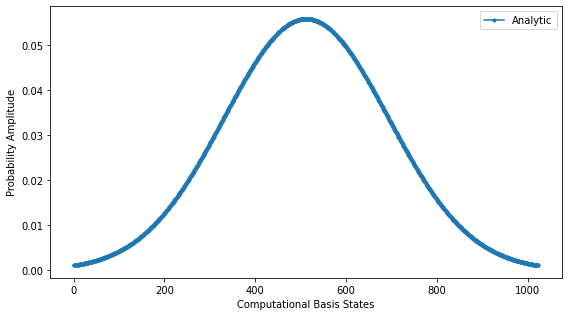

In [23]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.legend()
plt.tight_layout()
plt.show()

# 2.2 Exact MPS

We first prepare the target statevector exactly using our technique.

In [24]:
MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(y_tensor)

We consider singular values smaller than $10^{-15}$ to be non-zero only because of finite numerical precision and therefore drop them with `coarse_truncate_s_vals`. The threshold of $10^{-15}$ can be adjusted by supplying an argument to `coarse_truncate_s_vals`. We then redo the SVD but specify the ranks to obtain the "coarsely truncated" MPS cores. These will be defined as the new `MPS_cores_exact`.

In [25]:
coarse_truncated_s_vals = coarse_truncate_s_vals(s_vals_exact)
coarse_truncated_ranks = ranks_from_s_vals(coarse_truncated_s_vals)

MPS_cores_exact, s_vals_exact = MatrixProductState.svd_decompose(y_tensor, truncate_ranks=coarse_truncated_ranks)
MPS_exact = MatrixProductState(MPS_cores_exact)

Plot the singular values to visualize the entanglement in the system.

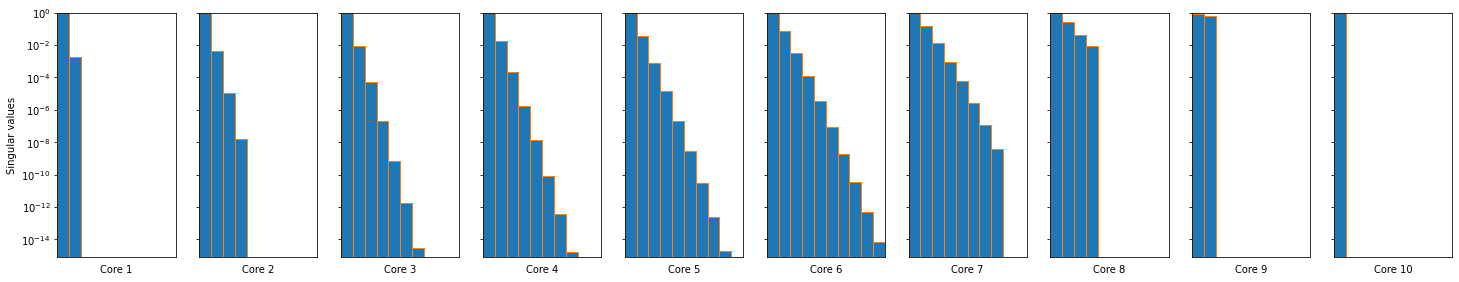

In [26]:
MPS_exact.plot_singular_values(s_vals_exact)

In [27]:
MPS_exact.right_normalize("F")
y_mps_exact = MPS_exact.get_all_amplitudes()

print(f"State Fidelity (Exact): {state_fidelity(y_amp, y_mps_exact):.5f}")

State Fidelity (Exact): 1.00000


## 2.2.1 Plot the target statevector and the amplitudes from the MPS cores

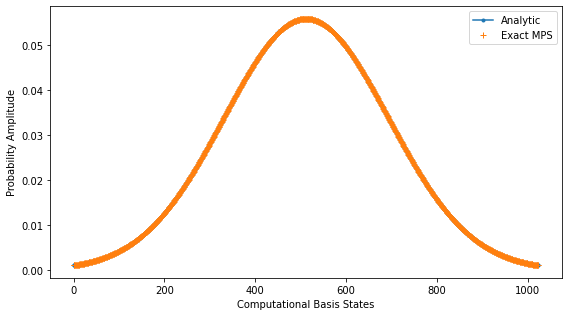

In [28]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.plot(x, np.abs(y_mps_exact), "+", label="Exact MPS")
plt.legend()
plt.tight_layout()
plt.show()

## 2.2.2 Use the MPI to generate the gate unitaries needed to prepare this state

In [29]:
MPI_exact = MatrixProductInitializer(MPS_exact)
unitaries_exact = MPI_exact.gate_unitaries(False)

In [30]:
# This cell may take 30s or so to run
if use_qiskit:
    operators = [Operator(unitary) for unitary in unitaries_exact]

    qc_exact = QuantumCircuit(MPI_exact.num_qubits)
    for m, operator in enumerate(operators):
        nqubit = int(np.log2(unitaries_exact[m].shape[-1]))
        qubits_list = list(range(m, m + nqubit))
        qc_exact.unitary(operator, qubits_list)

    qc_exact_basis = transpile(qc_exact, basis_gates=["u1", "u2", "u3", "cx"],
                               optimization_level=3)

    circuit_gates_exact = qc_exact_basis.count_ops()
    total_gates_exact = sum(qc_exact_basis.count_ops().values())
    circuit_depth_exact = qc_exact_basis.depth()

    print("Gate Count")
    for key, val in circuit_gates_exact.items():
        print(f"{key}: {val}")

    print(f"\nTotal Gates: {total_gates_exact}")
    print(f"Circuit Depth: {circuit_depth_exact}")

Gate Count
u3: 2989
cx: 2743
u1: 109
u2: 29

Total Gates: 5870
Circuit Depth: 5348


# 2.3 Approximate MPS

This time we try a successive approximation until a target fidelity has been reached. Again, we do a coarse truncation of singular values at every iteration to account for numerical precision errors during the SVD.

In [31]:
fidelity_target = 0.9999

s_vals_approx = s_vals_exact
ranks_history = []

print(15*" " + "Ranks" + 12*" " + "State Fidelity")
while True:
    s_vals_approx = coarse_truncate_s_vals(s_vals_approx)
    max_ratio_idx = best_s_val_truncation_idx(s_vals_approx)
    truncated_s_vals = truncate_s_vals(s_vals_approx, max_ratio_idx)
    truncated_ranks = ranks_from_s_vals(truncated_s_vals)
    ranks_history.append(truncated_ranks)

    MPS_cores_approx, s_vals_approx = MatrixProductState.svd_decompose(y_tensor,
                                                                       truncate_ranks=truncated_ranks)

    MPS_approx = MatrixProductState(MPS_cores_approx)
    MPS_approx.right_normalize("F")

    y_mps_approx = MPS_approx.get_all_amplitudes()

    fidelity = state_fidelity(y_amp, y_mps_approx)
    
    print("".join((3-len(str(i)))*" " + str(i) for i in truncated_ranks)
          + "  |  " + f"{fidelity:.5f}")
    
    if fidelity <= fidelity_target:
        print("\nSuccess!")
        break
    if np.all(truncated_ranks == 1):
        print("Truncated all ranks to 1 but fidelity still above target.")
        break

MPI_approx = MatrixProductInitializer(MPS_approx)
unitaries_approx = MPI_approx.gate_unitaries(False)

if use_qiskit:
    operators = [Operator(unitary) for unitary in unitaries_approx]

    qc_approx = QuantumCircuit(MPI_approx.num_qubits)
    for m, operator in enumerate(operators):
        nqubit = int(np.log2(unitaries_approx[m].shape[-1]))
        qubits_list = list(range(m, m + nqubit))
        qc_approx.unitary(operator, qubits_list)

    qc_approx_basis = transpile(qc_approx, basis_gates=["u1", "u2", "u3", "cx"],
                                optimization_level=3)

    circuit_gates_approx = qc_approx_basis.count_ops()
    total_gates_approx = sum(qc_approx_basis.count_ops().values())
    circuit_depth_approx = qc_approx_basis.depth()

    print("\nGate Count")
    for key, val in circuit_gates_approx.items():
        print(f"{key}: {val}")

    print(f"Total Gates: {total_gates_approx}")
    print(f"Circuit Depth: {circuit_depth_approx}")
    print(f"Ranks: {ranks_history[-2]}")

               Ranks            State Fidelity
  2  4  7  7  9 10  8  4  2  1  |  1.00000
  2  4  7  7  8 10  8  4  2  1  |  1.00000
  2  4  6  7  8 10  8  4  2  1  |  1.00000
  2  4  6  7  8  9  8  4  2  1  |  1.00000
  2  4  6  7  7  9  8  4  2  1  |  1.00000
  2  4  6  6  7  9  8  4  2  1  |  1.00000
  2  4  6  6  7  8  8  4  2  1  |  1.00000
  2  4  5  6  7  8  8  4  2  1  |  1.00000
  2  4  5  6  6  8  8  4  2  1  |  1.00000
  2  4  5  6  6  7  8  4  2  1  |  1.00000
  2  4  5  5  6  7  8  4  2  1  |  1.00000
  2  4  4  5  6  7  8  4  2  1  |  1.00000
  2  4  4  5  6  6  8  4  2  1  |  1.00000
  2  4  4  5  5  6  8  4  2  1  |  1.00000
  2  4  4  5  5  6  7  4  2  1  |  1.00000
  2  4  4  4  5  6  7  4  2  1  |  1.00000
  2  3  4  4  5  6  7  4  2  1  |  1.00000
  2  3  4  4  5  5  7  4  2  1  |  1.00000
  2  3  4  4  5  5  6  4  2  1  |  1.00000
  2  3  3  4  5  5  6  4  2  1  |  1.00000
  2  3  3  4  4  5  6  4  2  1  |  1.00000
  2  3  3  3  4  5  6  4  2  1  |  1.00000
  2  3 

## 2.3.1 Plot the target statevector and the amplitudes from the approx MPS cores

In [32]:
MPS_cores_approx, s_vals_approx = MatrixProductState.svd_decompose(y_tensor,
                                                                   truncate_ranks=ranks_history[-2])

MPS_approx = MatrixProductState(MPS_cores_approx)
MPS_approx.right_normalize("F")

y_mps_approx = MPS_approx.get_all_amplitudes()

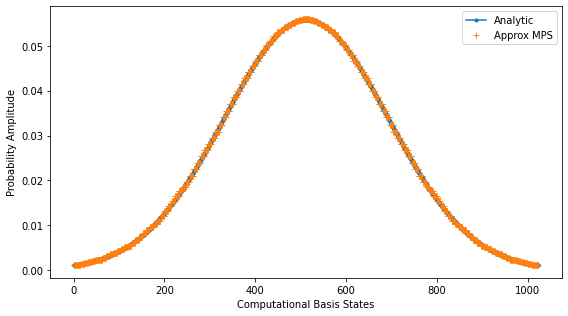

In [33]:
plt.figure(figsize=(8, 4.5))
plt.xlabel("Computational Basis States")
plt.ylabel("Probability Amplitude")
plt.plot(x, y_amp, ".-", label="Analytic")
plt.plot(x, np.abs(y_mps_approx), "+", label="Approx MPS")
plt.legend()
plt.tight_layout()
plt.show()

# 2.4 Compare exact state vs approximate state preparation

In [34]:
print("State Fidelity")
print(f"Exact  : {state_fidelity(y_amp, y_mps_exact):.5f}")
print(f"Approx : {state_fidelity(y_amp, y_mps_approx):.5f}")

if use_qiskit:
    print("\nGate Count")
    keys = set(circuit_gates_exact.keys()).union(set(circuit_gates_approx.keys()))
    print(10*" " + "    ".join(keys))
    print("Exact  : " + "".join((5-len(str(circuit_gates_exact.get(key, 0))))*" "
                                + str(circuit_gates_exact.get(key, 0)) for key in keys))
    print("Approx : " + "".join((5-len(str(circuit_gates_approx.get(key, 0))))*" "
                                + str(circuit_gates_approx.get(key, 0)) for key in keys))

    print("\nTotal Gates")
    print(f"Exact  : {total_gates_exact}")
    print(f"Approx : {total_gates_approx}")

    print("\nCircuit Depth")
    print(f"Exact  : {circuit_depth_exact}")
    print(f"Approx : {circuit_depth_approx}")

State Fidelity
Exact  : 1.00000
Approx : 0.99991

Gate Count
          cx    u2    u3    u1
Exact  :  2743   29 2989  109
Approx :    84   18   96   13

Total Gates
Exact  : 5870
Approx : 211

Circuit Depth
Exact  : 5348
Approx : 162
